In [1]:
import os
import sys
sys.path.append("../")
import csv
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import settings
from process_sentinel3 import OLCIdata, OLCIdataGenerator

### Define variables

In [2]:
DATA_PATH = settings.processed_data_path
fico_gt_path = os.path.join(settings.final_data_path, "gt.csv")
DATE_FORMAT = '%Y-%m-%d'

#contorno interno lat/lon
INTERNAL_CONTOUR = [[-34.85044049, -55.05341557], [-34.85254593, -55.06282895], [-34.84523452, -55.07215948], 
                    [-34.84214073, -55.08336897], [-34.83733203, -55.08595825], [-34.830501, -55.07932854], 
                    [-34.82322889, -55.07377278], [-34.81443658, -55.06745663], [-34.80518264, -55.06063834], 
                   [-34.79828906, -55.05565486], [-34.79200075, -55.04700809], [-34.80233605, -55.04418996],
                   [-34.81042967, -55.04493995], [-34.82011843, -55.04664643], [-34.82953074, -55.04855582],
                   [-34.83996726, -55.0500401], [-34.85044049, -55.05341557]]
# lon/lat
INTERNAL_CONTOUR_2 = [[coord[1], coord[0]] for coord in INTERNAL_CONTOUR]

## Read CSV containing GT into a DataFrame

In [3]:
ficocianina_df = pd.read_csv(fico_gt_path)
all_gt_dates = ficocianina_df.date.unique()
print(all_gt_dates)
print(f"Total dates in GT: {len(all_gt_dates)}")
ficocianina_df

['2015-12-30' '2016-01-07' '2016-01-13' '2016-01-23' '2016-01-27'
 '2016-02-03' '2016-02-10' '2016-02-18' '2016-02-24' '2016-03-02'
 '2016-03-10' '2016-03-22' '2016-03-29' '2016-04-07' '2016-12-01'
 '2016-12-09' '2016-12-16' '2016-12-22' '2017-01-02' '2017-01-11'
 '2017-01-18' '2017-01-24' '2017-02-02' '2017-02-08' '2017-02-15'
 '2017-02-22' '2017-03-01' '2017-03-08' '2017-03-23' '2017-03-31'
 '2017-04-07' '2017-12-07' '2017-12-28' '2018-01-03' '2018-01-11'
 '2018-01-18' '2018-01-25' '2018-01-31' '2018-02-08' '2018-02-15'
 '2018-02-22' '2018-03-01' '2018-03-07' '2018-03-26' '2018-04-05'
 '2018-04-18' '2018-11-13' '2018-11-20' '2018-11-30' '2018-12-13'
 '2018-12-20' '2018-12-28' '2019-01-04' '2019-01-11' '2019-01-18'
 '2019-01-24' '2019-01-31' '2019-02-07' '2019-02-15' '2019-02-21'
 '2019-03-01' '2019-03-07' '2019-03-14' '2019-03-22' '2019-03-29'
 '2019-04-04' '2019-04-12' '2019-05-18' '2019-08-01' '2019-09-22'
 '2019-11-06' '2019-11-15' '2019-11-27' '2019-12-13' '2019-12-23'
 '2019-12-

,date,location,fico,chl
0,2015-12-30,MALLORQUINA,5032.50,10.00
1,2015-12-30,ARROYO SAUCE,5345.50,21.80
2,2015-12-30,SAUCE NORTE,4282.50,7.50
3,2015-12-30,SAUCE SUR,5388.00,7.50
4,2015-12-30,CISNES,9082.50,18.45
...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN
686,2020-11-01,TA,47.00,NaN
687,2020-11-02,TA,5.96,NaN
688,2020-11-05,TA,9.06,NaN


In [35]:
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=False,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

data_generator_skip_invalid = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=True,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

### Satellite availability

In [11]:
first_sentinel3B_date = "2018-11-30"

In [6]:
fico_df_after_s3b = ficocianina_df[ficocianina_df["date"] >= first_sentinel3B_date]

days_after_s3b_all = [d for d in data_generator if d.date >= datetime.strptime(first_sentinel3B_date, "%Y-%m-%d")]
satellite_acquisition_all = round(len(days_after_s3b_all)/len(fico_df_after_s3b["date"].unique()),2)
print(f"Sentinel-3 acquisition rate after S-3B: {satellite_acquisition_all}")

days_after_s3b_skip_invalid = [d for d in data_generator_skip_invalid if d.date >= datetime.strptime(first_sentinel3B_date, "%Y-%m-%d")]
satellite_acquisition_clear =  round(len(days_after_s3b_skip_invalid)/len(fico_df_after_s3b["date"].unique()), 2)
print(f"Sentinel-3 acquisition rate after S-3B without clouds: {satellite_acquisition_clear}")

Sentinel-3 acquisition rate after S-3B: 1.18
Sentinel-3 acquisition rate after S-3B without clouds: 0.43


In [60]:
BLOOM_THRESHOLD = 7000

In [37]:
bloom_df = ficocianina_df[ficocianina_df["fico"] >= BLOOM_THRESHOLD]
bloom_dates = bloom_df.date.unique()

y_gt = []
y_pred = []
for day in data_generator_skip_invalid:
    if day.date >= datetime.strptime(first_sentinel3B_date, "%Y-%m-%d"):
        immersed_mask = day.mph.immersed_cyanobacteria*day.mask
        count_immersed = np.count_nonzero(immersed_mask)
        floating_mask = day.mph.floating_cyanobacteria*day.mask
        count_floating = np.count_nonzero(day.mph.floating_cyanobacteria*day.mask)
        count_total = count_immersed + count_floating

        y_pred.append(count_total > 100)

        day_fico_df = ficocianina_df[ficocianina_df["date"] == str(day.date.date())]
        fico_mean = day_fico_df[day_fico_df["location"].isin(["SAUCE NORTE", "SAUCE SUR", "TA"])]["fico"].mean()
        y_gt.append(fico_mean > BLOOM_THRESHOLD)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(y_gt, y_pred)
sns.heatmap(conf, annot=True)

acc = accuracy_score(y_gt, y_pred)
print("Accuracy:", round(acc, 2))

In [61]:
sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.831010, -55.043338]}

data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

for olci_data in data_generator:
    # use only dates after sentinel-3b was launched
    if olci_data.date >= datetime.strptime(first_sentinel3B_date, "%Y-%m-%d"):
        # get gt data for same date as satellite data
        day_fico_df = ficocianina_df[ficocianina_df["date"] == str(olci_data.date.date())]
        # iterate over rows, skipping unwanted sample locations
        for index, row in day_fico_df.iterrows():
            if not (row["location"] in y_gt):
                continue
            olci_data.create_sparse_mask([sampling_points_coords[row["location"]]])
            immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
            count_immersed = np.count_nonzero(immersed_mask)
            floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
            count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
            count_total = count_immersed + count_floating
            
            y_pred[row["location"]].append(count_total > 0)
            y_gt[row["location"]].append(row["fico"] > BLOOM_THRESHOLD)

Accuracy: 0.84


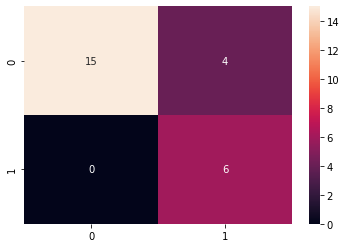

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(y_gt["SAUCE NORTE"], y_pred["SAUCE NORTE"])
sns.heatmap(conf, annot=True)

acc = accuracy_score(y_gt["SAUCE NORTE"], y_pred["SAUCE NORTE"])
print("Accuracy:", round(acc, 2))

Accuracy: 0.92


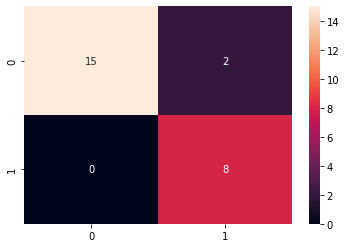

In [63]:
conf = confusion_matrix(y_gt["SAUCE SUR"], y_pred["SAUCE SUR"])
sns.heatmap(conf, annot=True)

acc = accuracy_score(y_gt["SAUCE SUR"], y_pred["SAUCE SUR"])
print("Accuracy:", round(acc, 2))

Accuracy: 0.74


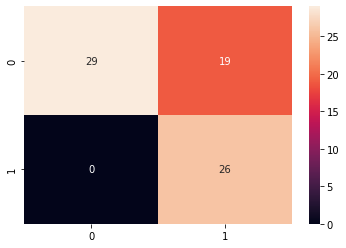

In [64]:
conf = confusion_matrix(y_gt["TA"], y_pred["TA"])
sns.heatmap(conf, annot=True)

acc = accuracy_score(y_gt["TA"], y_pred["TA"])
print("Accuracy:", round(acc, 2))